# Analysis of Transaction Wait Times across Multi-Site Databases 

This notebook primarily deals with extracting, manipulating, and analyzing data from a specific database server named `'NESTOR'`. It begins by establishing a connection to the server using the SQLAlchemy library, utilizing the necessary credentials and the server's parameters. The notebook then focuses on retrieving data from a table named `'jobtran'` across various databases corresponding to different sites, with a date filter applied to isolate recent transactions. The data, once extracted, undergoes preprocessing, which involves time conversion, filtering based on specific criteria, and computation of time intervals between specific transaction types. The main analytical thrust of the notebook centers around evaluating wait times between specific transaction pairs, and it ultimately computes the percentage of intervals where this wait time exceeds 20 minutes. A site reference dictionary (`site_ref_dict`) is provided to support this, linking site codes to their respective app names and time zones, with international sites being intentionally excluded.

The script imports essential libraries for database connections, data manipulation, and visualization:

In [139]:
# SQLAlchemy is an Object Relational Mapper (ORM) that connects Python programs to databases.
# It provides an efficient and high-level API for connecting to relational databases.
import sqlalchemy

# urllib.parse module provides functions for manipulating URLs and query strings.
# This might be used later in the code to handle database connection URLs or manipulate web URLs.
import urllib.parse

# pandas is a powerful Python library for data manipulation and analysis.
# It provides data structures like DataFrame and Series that make it easy to organize and analyze data.
import pandas as pd

# NumPy is a fundamental package for numerical computations in Python.
# It provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays.
import numpy as np

# matplotlib is a 2D plotting library for Python. It allows for creating static, animated, and interactive visualizations.
# The `pyplot` module in matplotlib provides a MATLAB-like interface for plotting.
import matplotlib.pyplot as plt

The script defines a site_ref_dict dictionary that associates U.S. site codes with their respective applications and time zones. Notably, some international sites are commented out, as they don't utilize the ADP system.

In [140]:
# Given comment indicates that international sites are excluded because ADP (probably a system or service)
# isn't used for international sites.

# A dictionary that maps site reference codes to a list containing two values:
# 1. The application name/code associated with the site.
# 2. The time zone in which the site operates.
# This mapping can be beneficial for systems that need to work with site-specific applications and time zones.

site_ref_dict = {
    # The following sites have been commented out, because they are international sites:
    
    # "BGK"      :['BGK_App', 'Asia/Bangkok'],
    # "BLIS"     :['BLIS_App', 'Europe/London'],
    "CORP"     :['Corp_App', 'America/New_York'],
    "DenverPA" :['DenverPA_App', 'America/New_York'],
    "HOPE"     :['HOPE_App', 'America/Chicago'],
    "LEB"      :['LEB_App', 'America/New_York'],
    "MBRG"     :['MBRG_App', 'America/New_York'],
    # "PRG"      :['PRG_App', 'Europe/Prague'],
    "RDG"      :['Rdg_App', 'America/New_York'],
    "USREV"    :['USRevenue_App' , 'America/Tijuana'],
    "RdgWhse"  :['RdgWhse_App' , 'America/New_York'] ,
    # "VAD"      :['VAD_App', 'Asia/Kolkata'],
    }

The script connects to the 'NESTOR' SQL Server and fetches job transaction records post August 1, 2023, from multiple sites. This data is consolidated into a single DataFrame for further analysis.

In [141]:
# The name of the server is defined as 'NESTOR'. This is typically the address or the identifier of the database server.
server_name = 'NESTOR'

# Set up the connection string for the database:
# - `Driver={SQL Server}` specifies that the database we are connecting to is an SQL Server.
# - `Server=NESTOR` points to the server defined above.
# - `Trusted_Connection=yes` indicates that the authentication is done through the logged-in user's credentials.
params = urllib.parse.quote_plus('Driver={SQL Server};Server=NESTOR;Trusted_Connection=yes;')

# Create a database engine connection using SQLAlchemy. This is the main entry point to any SQL operations.
# The database being connected to is using the `mssql+pyodbc` dialect, which means it's an SQL Server accessed via the pyodbc driver.
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))

# Define a date filter for the upcoming SQL queries. Only records after this date will be considered.
filter_date = '2023-08-01'

#############################################################################################################################
#############################################################################################################################

# The purpose of this section is to extract data from the "jobtran" table across different databases (sites).
# For each site in the `site_ref_dict` dictionary, a query is executed to extract records after a certain date (`filter_date`).

# Initialize an empty DataFrame to store the combined data from all the sites.
df_jobtran = pd.DataFrame()    

# Iterate over each site in the dictionary to fetch data:
for site in site_ref_dict:
    
    # For each site, the name of the database (app name) is derived from the `site_ref_dict` dictionary.
    database = site_ref_dict[site][0]
    
    # Construct the SQL query for fetching data. It selects all columns from the `jobtran` table 
    # for records that have a `RecordDate` after the specified `filter_date`.
    query_Nestor  = f"""
                    SELECT *
                    FROM [{database}].[dbo].[jobtran] 
                    WHERE [RecordDate] >= '{filter_date}'
                    """
    
    # Execute the SQL query using the database engine and store the results in a DataFrame.
    df_nestor = pd.read_sql_query(query_Nestor, engine)
    
    # Insert a new column, 'SiteRef', to the DataFrame, indicating which site the data belongs to. 
    # This is beneficial for future analyses that want to distinguish data by site.
    df_nestor.insert(loc=0, column='SiteRef', value=[site]*len(df_nestor))
    
    # Append the data fetched for the current site to the main DataFrame (`df_jobtran`).
    df_jobtran = pd.concat([df_jobtran, df_nestor], ignore_index=True)


This code serves to analyze transactional data related to different sites and their associated employees, aiming to deduce insights about specific time intervals.

## Steps:
#### Filtering Employees:

For each site in the site_ref_dict, the code extracts unique employee numbers associated with a certain transaction type ('I',  standing for 'Iniderct' - Clock_ins).

The code filters out non-human entries, identified by a '-' in their ID. This might represent machines or other entities.

#### Time Conversion & Data Cleaning:

The code converts the 'start_time' from seconds to a more human-readable time difference format.
It then combines this with the 'trans_date' to create a full datetime column.
The data is filtered for relevant transactions (types 'I' and 'R'), sorted by the transaction time, and further filtered to include only the relevant employees.

#### Calculate Time Differences:

The objective here is to calculate the time difference between an 'Indirect' transaction and the next operation - 'Job' transactions.

This is done for each employee, storing the differences in minutes.

#### Analyze Time Differences:

The code then determines the percentage of instances where the time difference is greater than 20 minutes, signaling a potential inefficiency or waiting period.
The results are printed out for each site, either displaying the percentage or indicating that there's insufficient data to make a conclusion.
Outcome:
By the end, we have a clear understanding of how often employees at different sites experience waiting times (or other operations) exceeding 20 minutes.

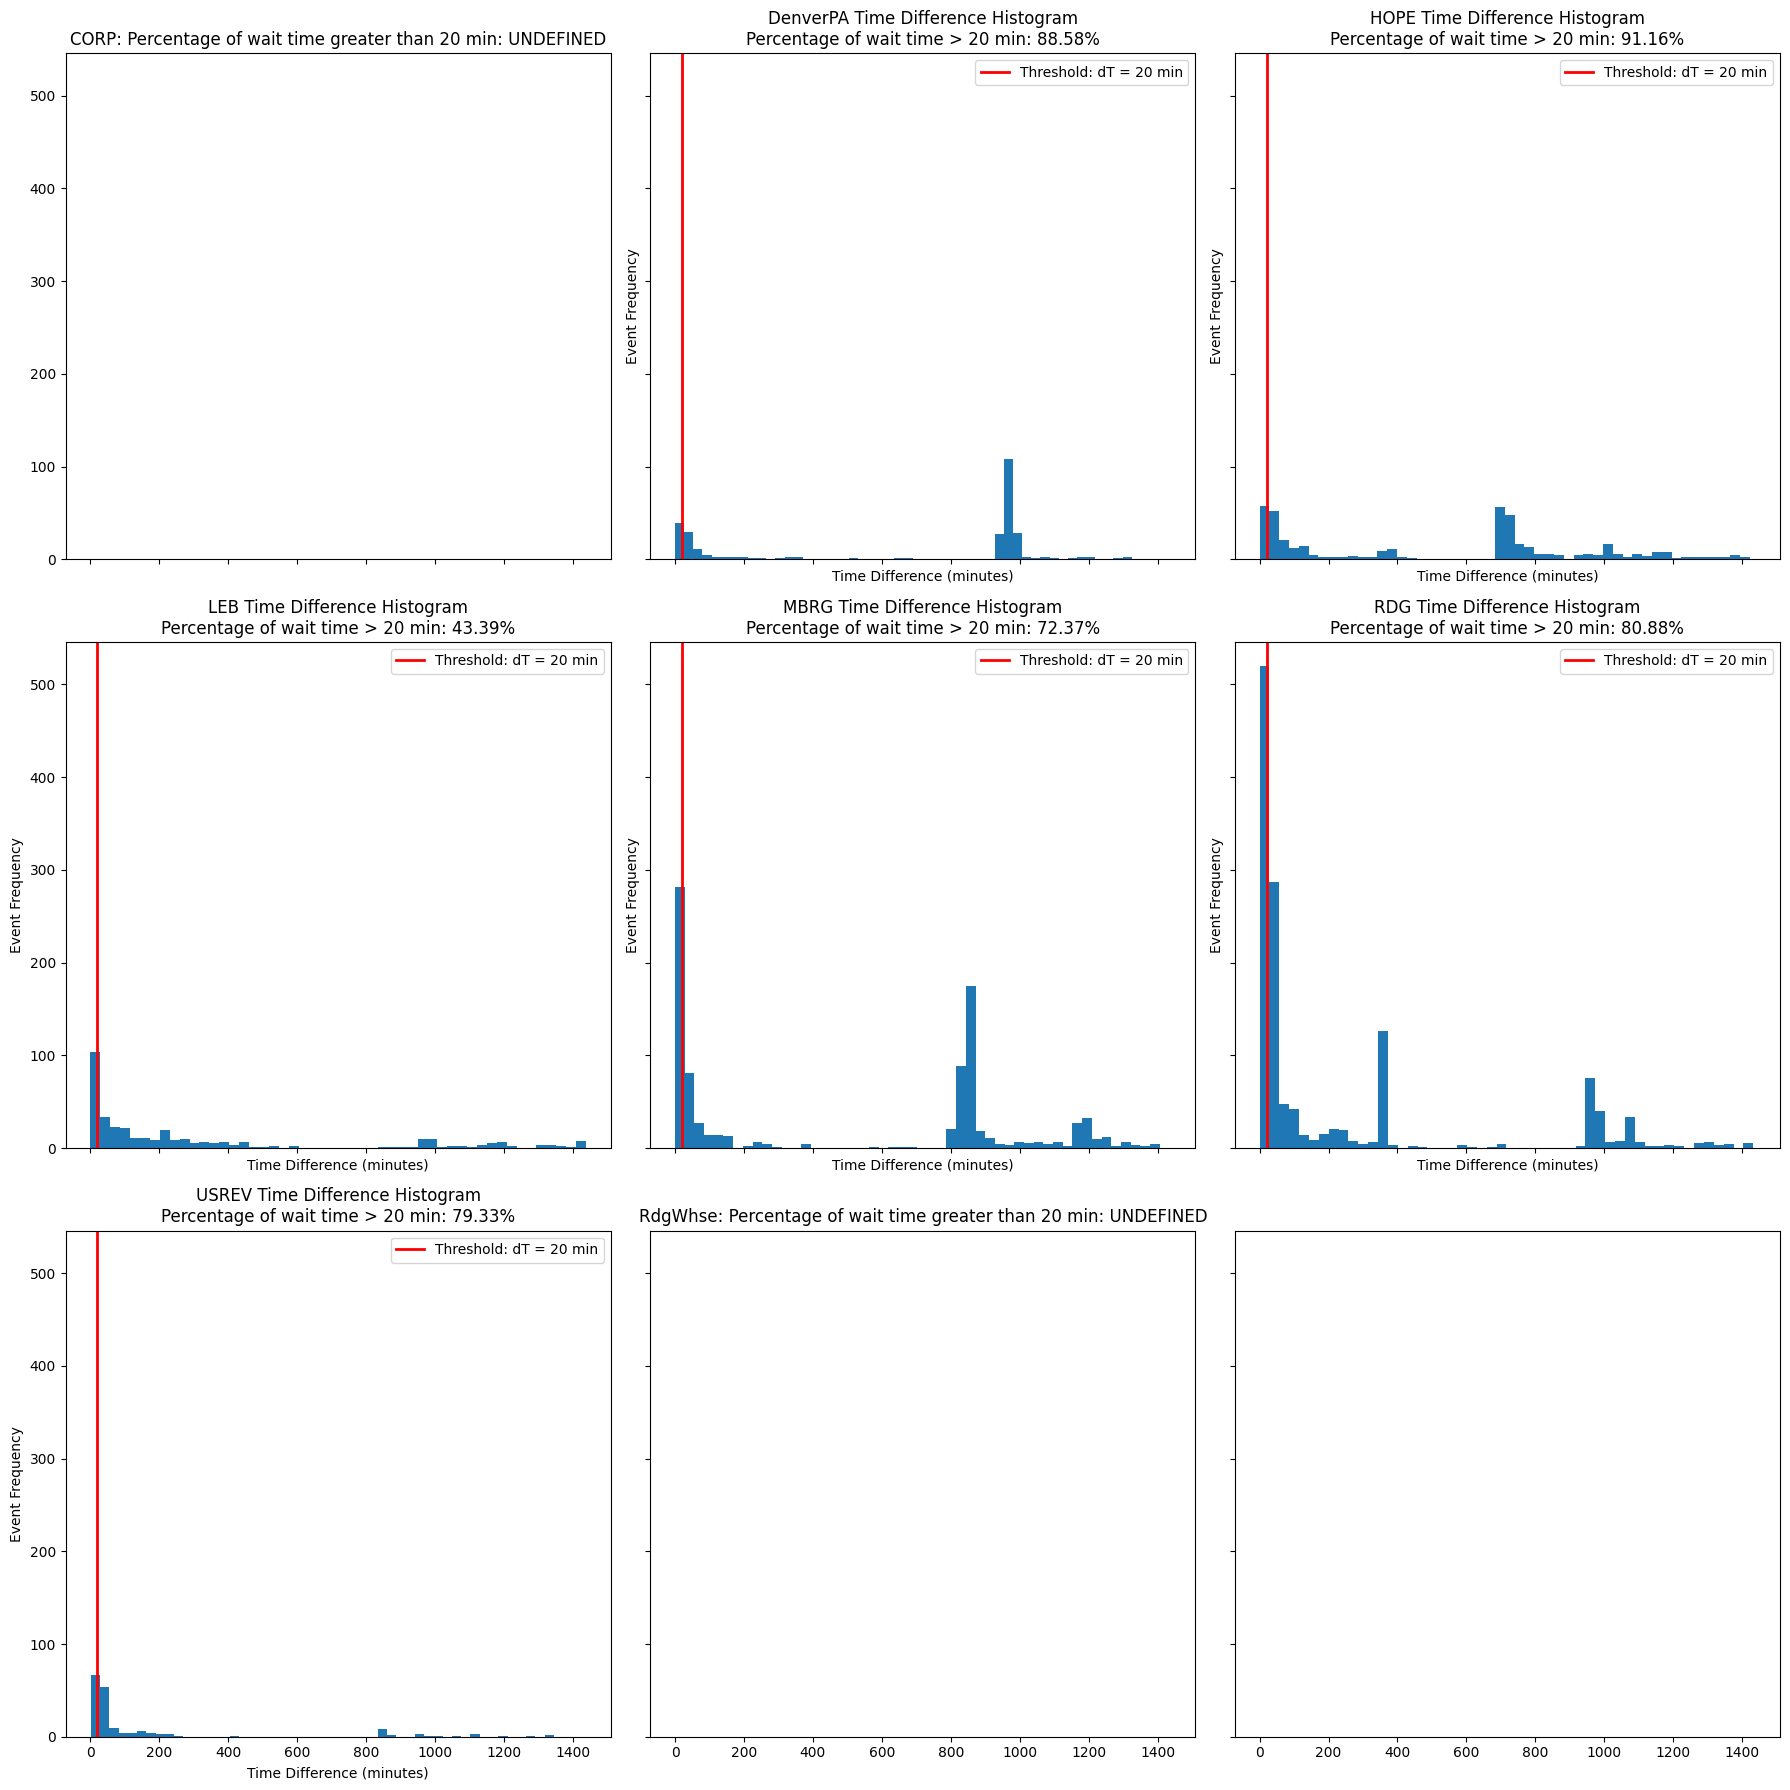

In [150]:
# Initialize a 3x3 grid of subplots with shared x and y axes, set the figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), sharex=True, sharey=True)

# Flatten the 2D array of axes for easy iteration
flat_axes = axes.ravel()

# Iterate through each site and its corresponding axis
for ax, site in zip(flat_axes, site_ref_dict):

    # Step 1: Filtering employees from the data:
    # Extract unique employee IDs for the current site and transaction type 'I'
    uniq_emp = df_jobtran[
        (df_jobtran['SiteRef'] == site) &
        (df_jobtran['trans_type'] == 'I')]['emp_num'].unique()
    
    # Filter out employee IDs with '-' characters
    uniq_emp_filter = [emp_id for emp_id in uniq_emp if '-' not in emp_id]

    #########################################################################################

    # Step 2: Time conversion and creation of new columns:
    # Convert 'start_time' column to timedelta format
    df_jobtran['start_time'] = pd.to_timedelta(df_jobtran['start_time'], unit='s')
    
    # Calculate 'trans_time' by adding 'trans_date' and 'start_time'
    df_jobtran['trans_time'] = df_jobtran['trans_date'] + df_jobtran['start_time']

    # Filter and sort the data for indirect transactions
    df_jobtran_clean = df_jobtran[
        (df_jobtran['SiteRef'] == site) &
        (df_jobtran['trans_type'].isin(['I', 'R']))
    ].sort_values(by='trans_time')

    # Extract relevant columns for indirect jobs
    df_job_indirect = df_jobtran_clean[df_jobtran_clean['emp_num'].isin(uniq_emp_filter)][['emp_num', 'trans_type', 'trans_time']]

    #############################################################################################

    # Step 3: Calculate the time differences:
    time_diff_list = []
    
    # Group the data by employee number
    grouped = df_job_indirect.groupby('emp_num')
    
    for emp, group in grouped:
        clock_in_time = None
        for idx, row in group.iterrows():
            if row['trans_type'] == 'I':
                clock_in_time = row['trans_time']
            elif row['trans_type'] == 'R' and clock_in_time is not None:
                # Calculate time difference in minutes and append to the list
                time_diff = (row['trans_time'] - clock_in_time).seconds / 60
                time_diff_list.append(time_diff)
                clock_in_time = None

    # Step 4: Calculate the percentage of time differences greater than 20 minutes:
    count_gt_20 = sum(1 for diff in time_diff_list if diff > 20)
    
    if len(time_diff_list) != 0:
        percentage_gt_20 = (count_gt_20 / len(time_diff_list)) * 100
        
        #####################################################################################################
        # Plotting Histogram for each site (using the available data)
        
        # Use the current ax object for plotting
        ax.hist(time_diff_list, bins=50)
        ax.axvline(x=20, color='red', linestyle='-', linewidth=2, label='Threshold: dT = 20 min')
        ax.legend()
        ax.set_title(f'{site} Time Difference Histogram\nPercentage of wait time > 20 min: {percentage_gt_20:.2f}%')
        ax.set_xlabel('Time Difference (minutes)')
        ax.set_ylabel('Event Frequency')
    else:
        ax.set_title(f'{site}: Percentage of wait time greater than 20 min: UNDEFINED')

#####################################################################################################
# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()
